# Code Generation using GPT2

GPT2 is LLM that is originally from OpenAI, and it's licensed under MIT License.<br>
https://huggingface.co/docs/transformers/en/model_doc/gpt2


trained GPU: NVIDIA RTX 6000 Ada Generation <br>
trained time: 1d 2h 22m 41s

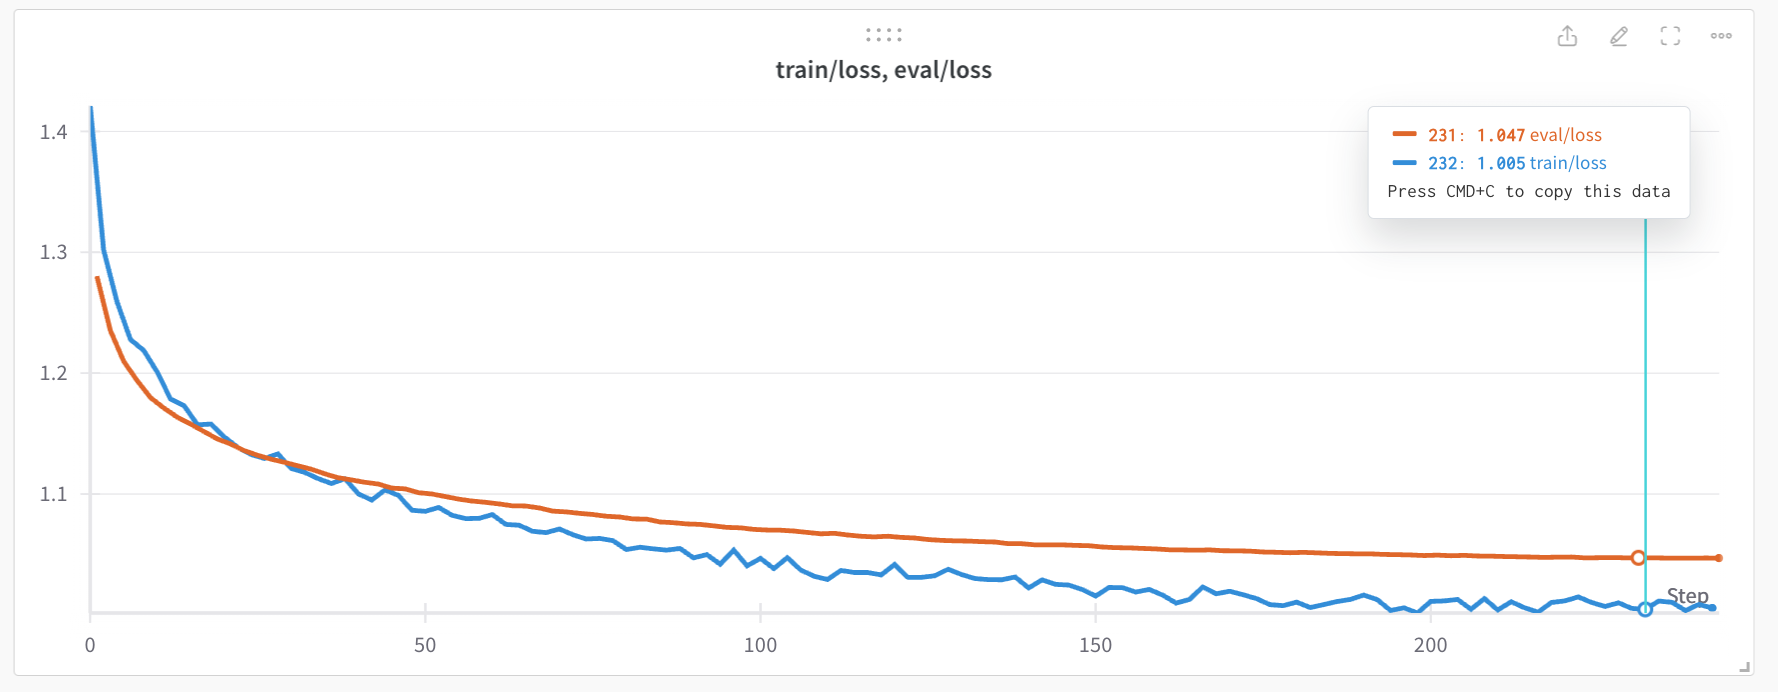

In [ ]:
# # installation
# !pip install transformers datasets

In [1]:
import torch
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset, concatenate_datasets

## Get Code dataset

In [105]:
code_dataset_train = load_dataset("code_search_net", "python", split="train")
code_dataset_validation = load_dataset("code_search_net", "python", split="validation")

# sample portion of the data
def trainDataPct(dataset, pct=1):
    return dataset.select(range(int(len(dataset)*pct)))

code_dataset_train = trainDataPct(code_dataset_train, pct=0.3)
code_dataset_validation = trainDataPct(code_dataset_validation, pct=0.3)

df_train = code_dataset_train.to_pandas()

Found cached dataset code_search_net (/net/papilio/storage7/phusaeng/.cache/huggingface/datasets/code_search_net/python/1.0.0/8f2524e6b62f65af5f5d65c53715c654db7b08dc93e0b7bcce2ab2f286a75be1)
Found cached dataset code_search_net (/net/papilio/storage7/phusaeng/.cache/huggingface/datasets/code_search_net/python/1.0.0/8f2524e6b62f65af5f5d65c53715c654db7b08dc93e0b7bcce2ab2f286a75be1)


In [106]:
def get_sample():
    # randomly pick index for a row to be displayed
    idx = torch.randint(0, len(df_train), (1,)).item()
    # Get the text descriptions according to the selected idx
    func_doc_str = df_train["func_documentation_string"][idx]
    func_name = df_train["func_name"][idx]
    whole_func_string = df_train["whole_func_string"][idx]
    # create query and answer prompts
    query = """Please write a function that {instruction}"""
    fucntion_name = """\n\nThe function name is: {func_name}"""
    out = query.format(instruction=func_doc_str) + fucntion_name.format(func_name=func_name) + "\n\n" + whole_func_string
    print(out)

get_sample()

Please write a function that Create a program and add it to this MultiProgram.
        
        It is the caller's responsibility to keep a reference to the returned 
        program.
        
        The *name* must be unique, but is otherwise arbitrary and used for 
        debugging purposes.

The function name is: MultiProgram.add_program

def add_program(self, name=None):
        """Create a program and add it to this MultiProgram.
        
        It is the caller's responsibility to keep a reference to the returned 
        program.
        
        The *name* must be unique, but is otherwise arbitrary and used for 
        debugging purposes.
        """
        if name is None:
            name = 'program' + str(self._next_prog_id)
            self._next_prog_id += 1
                
        if name in self._programs:
            raise KeyError("Program named '%s' already exists." % name)
        
        # create a program and update it to look like the rest
        prog = Mo

## Get GPT2

In [107]:
# tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")
# model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

## Preprocess dataset

In [108]:
def preprocess_function(examples):
    """ prompt template for training the LM """
    # print(examples["func_documentation_string"], examples["func_name"], examples["whole_func_string"])
    query = """Please write a function that {instruction}"""
    fucntion_name = """\n\nThe function name is: {func_name}"""
    out_list = [
        query.format(instruction=func_doc_str) + fucntion_name.format(func_name=func_name) + "\n\n" + whole_func_string
        for func_doc_str, func_name, whole_func_string in 
        zip(examples["func_documentation_string"], examples["func_name"], examples["whole_func_string"])
    ]
    out = tokenizer(out_list)
    return out

tokenized_train = code_dataset_train.map(
    preprocess_function,
    batched=True,
    num_proc=16,
    remove_columns=code_dataset_train.column_names
)
tokenized_validation = code_dataset_validation.map(
    preprocess_function,
    batched=True,
    num_proc=16,
    remove_columns=code_dataset_validation.column_names
)

Map (num_proc=16):   0%|          | 0/123653 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1140 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3164 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2688 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1937 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1374 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Map (num_proc=16):   0%|          | 0/6932 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1094 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5290 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1362 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3510 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1447 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

In [109]:
def group_texts(examples):
    block_size = 1024
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()} # sum of list is concatenation
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train = tokenized_train.map(
    group_texts,
    batched=True,
    num_proc=16,
)
tokenized_validation = tokenized_validation.map(
    group_texts,
    batched=True,
    num_proc=16,
)

Map (num_proc=16):   0%|          | 0/123653 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/6932 [00:00<?, ? examples/s]

## Fine-tuning the model

In [38]:
run_name = "gpt2-python-code-search-test"
out_dir = f"out/{run_name}"
batch_size = 7
training_args = TrainingArguments(
    output_dir=out_dir,
    run_name=run_name,
    evaluation_strategy="steps",
    save_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=500,
    save_steps=500,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation.shuffle(42).select(range(300)), # only use 300 examples for validation
    data_collator=data_collator,
)

trainer.train()

/net/papilio/storage6/phusaeng/anaconda3/envs/pytorch2/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 